In [1]:
from psaw import PushshiftAPI
import praw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

In [2]:
creds = {}
with open ('/opt/cap1/.cap1', 'r') as fp:
    for line in fp:
        k, v = line.replace('\n','').split('\t')
        creds[k] = v

In [3]:
reddit = praw.Reddit(client_id=creds['REDDIT_ID'], 
    client_secret=creds['REDDIT_SECRET'],
    password=creds['REDDIT_PASSWORD'], 
    username=creds['REDDIT_USERNAME'],
    user_agent='accessAPI:v0.0.1 (by /u/{})'.format(creds['REDDIT_USERNAME']))

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [5]:
!pwd

/home/ubuntu/src/troll_classifier


In [6]:
susp_usrs = pd.read_csv('data/user_activity_dataframe.csv')
susp_usrs.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
susp_usrs

,username,type,subreddit,count
0,BlackToLive,comment,politics,3
1,BlackToLive,submission,BlackLivesMatter,7
2,BlackToLive,submission,Bad_Cop_No_Donut,4
3,BlackToLive,submission,blackculture,3
4,BlackToLive,submission,blackpower,3
...,...,...,...,...
3820,rubinjer,submission,holdthemoan,1
3821,rubinjer,submission,michaelbaygifs,1
3822,rubinjer,submission,milf,1
3823,rubinjer,submission,nsfw_wtf,1


In [8]:
# suspicious users posted to 939 unique subreddits ... odd b/c there are 939 unique suspicious 
#  usernames on Reddit's transparency report
sub_unq = np.unique(susp_usrs['subreddit'])
len(sub_unq), sub_unq[:20]

(939,
 array(['100BlackMen', '2016_elections', '3DPorncraft', '3Dprinting',
        '4chan', '60fpsporn', 'A858DE45F56D9BC9', 'ANormalDayInAmerica',
        'ANormalDayInRussia', 'AccidentalRacism', 'AdvancedMicroDevices',
        'Advice', 'AdviceAnimals', 'Africa', 'AfricanAmerican', 'Agario',
        'AgeplayPenPals', 'AirForce', 'Alabama', 'Albuquerque'],
       dtype=object))

In [9]:
# 333 of the 939 suspicious users posted a comment or submission
usr_unq = np.unique(susp_usrs['username'])
len(usr_unq), usr_unq[:20]

(333,
 array(['1488Reasons', 'Abena_Tau', 'AdoraronDoomworker',
        'AgaluneMalordred', 'AgamagelvTozshura', 'Aiden_Chuck',
        'Albert_Baldwin', 'AlsagelvBuriron', 'Amohelang',
        'AndromajurusAragrel', 'AndrorneGavinrage', 'AragelvBlackkiller',
        'AralisTugis', 'AriundisVugar', 'AriutusMokazahn',
        'AxeseekerMightwind', 'BagoreZulkihn', 'BallardredTholak',
        'BeazerneMem', 'BerskyN'], dtype=object))

In [10]:
#### there are 939 suspicious users on Reddit's list. 939...oddly specific match 
#### to the number of unique subreddits to which the 939 accounts posted
!wc -l data/suspicious_users.txt

939 data/suspicious_users.txt


In [11]:
# would like to get the very first and the very last post/comment from each user to get the time span of the data
api = PushshiftAPI()

In [ ]:
def first_last(table, **kwargs):
    '''
    retrieve the first and last submission and comment for the user
    '''
    sort_types = ('desc', 'asc')
    kwargs['limit'] = 1
    search_types = (api.search_submissions, api.search_comments)
    for search_type in search_types:
        for sort_type in sort_types:
            kwargs['sort'] = sort_type
            gen = search_type(**kwargs)
            for g in list(gen):
                print(g.d_)
                table.insert_one(g.d_)

In [9]:
table = db['first_and_last']

In [ ]:
# this gets the first and last comment and submission for each suspicious user to get the timeframe of user activity
susp_usrs = pd.read_csv('data/user_activity_dataframe.csv')
susp_usrs.drop('Unnamed: 0', axis=1, inplace=True)
    
# first_last(author='DeusXYX')
for usr in np.unique(susp_usrs['username']):
    print(f'Author: {usr}')
    first_last(table, author=usr)
    print()

In [10]:
submissions = []
comments = []
for doc in table.find({}, {'_id': 0}):
    if 'title' in doc:
        submissions.append(doc)
    elif 'body' in doc:
        comments.append(doc)

In [11]:
print('Document counts ...')
print(f'submissions: {len(submissions)}')
print(f'comments: {len(comments)}')
print(f'total: {len(submissions) + len(comments)}')

Document counts ...
submissions: 666
comments: 298
total: 964


## we have the first and last comments and submissions for each user. How many users commented? submitted? Over what time frame?

#### I didn't initially store whether a document was a submission or comment, but we use the 'title' and 'body' keys to distinguish them. All documents accounted for, with 658 submissions and 294 comments

In [12]:
subs_df = pd.DataFrame.from_dict(submissions)
comms_df = pd.DataFrame.from_dict(comments)

In [13]:
# set the index to datetime using the timestamp in 'created_utc'
comms_df.index = [dt.fromtimestamp(x) for x in comms_df['created_utc']]
subs_df.index = [dt.fromtimestamp(x) for x in subs_df['created_utc']]

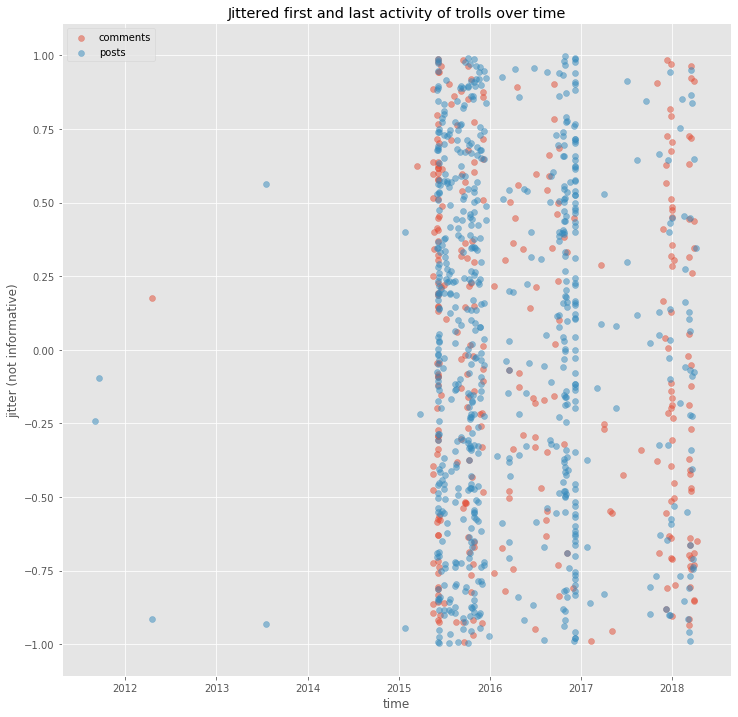

In [30]:
# show me the data!
fig, ax = plt.subplots(1, figsize=(12, 12))
dat_type = ['comments', 'posts']
for i, dat in enumerate([comms_df, subs_df]):
    range_dat = dat
    jitter = stats.uniform(-1, 2).rvs(len(range_dat))
    ax.scatter(range_dat.index, jitter, label=dat_type[i], alpha=0.5)
    ax.set_title('Jittered first and last activity of trolls over time')
ax.set_ylabel('jitter (not informative)')
ax.set_xlabel('time')
ax.legend();

#### just look at the activity leading up to the election after the action starts in 2015

In [14]:
date_start='2015-05'
date_end='2017-01'
len(comms_df[date_start:date_end])

205

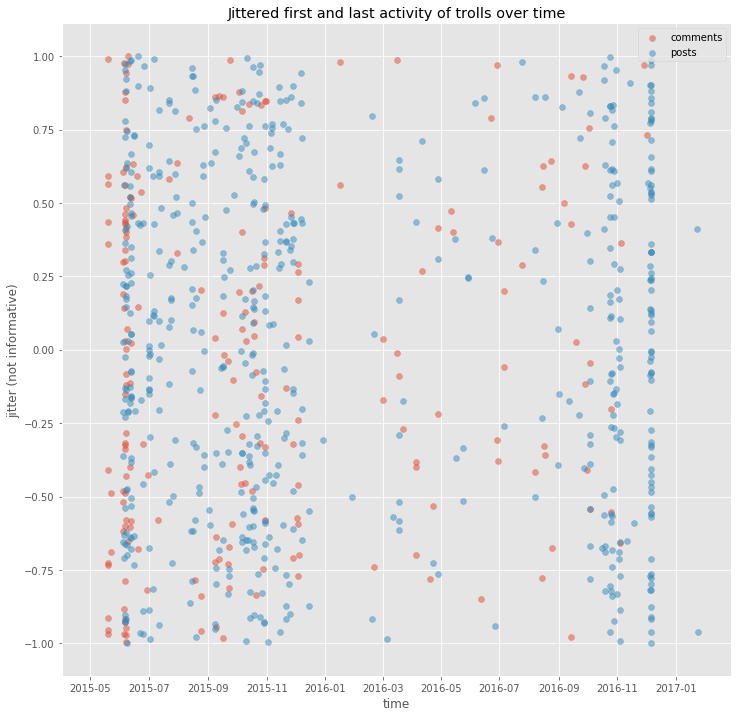

In [15]:
# show me the data!
fig, ax = plt.subplots(1, figsize=(12, 12))
dat_type = ['comments', 'posts']
for i, dat in enumerate([comms_df, subs_df]):
    range_dat = dat[date_start:date_end]
    jitter = stats.uniform(-1, 2).rvs(len(range_dat))
    ax.scatter(range_dat.index, jitter, label=dat_type[i], alpha=0.5)
    ax.set_title('Jittered first and last activity of trolls over time')
ax.set_ylabel('jitter (not informative)')
ax.set_xlabel('time')
ax.legend();

#### what do these spikes of activity look like when resampled by day/hour?

In [33]:
# HOURLY
subs_hourly = subs_df['created_utc'].resample('H').count()
comms_hourly = comms_df['created_utc'].resample('H').count()

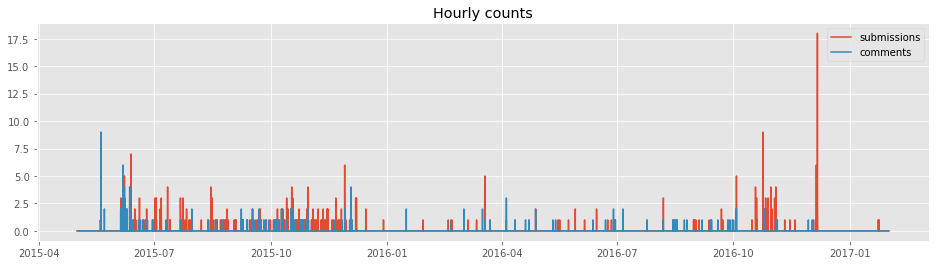

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(subs_hourly[date_start:date_end], label='submissions')
ax.plot(comms_hourly[date_start:date_end], label='comments')
ax.set_title("Hourly counts")
ax.legend()

In [35]:
# DAILY
subs_daily = subs_df['created_utc'].resample('D').count()
comms_daily = comms_df['created_utc'].resample('D').count()

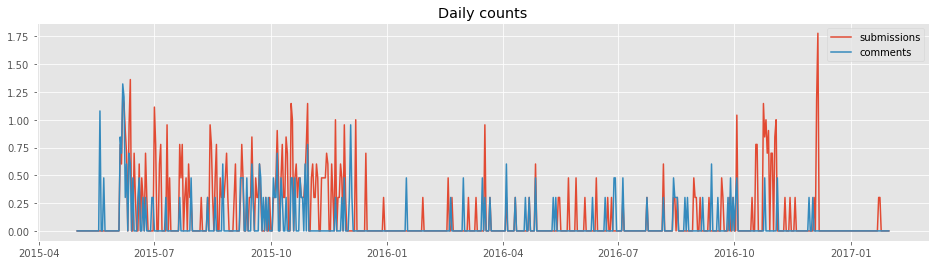

In [36]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(np.log10(subs_daily[date_start:date_end]+1), label='submissions', scaley='log')
ax.plot(np.log10(comms_daily[date_start:date_end]+1), label='comments', scaley='log')
ax.set_title("Daily counts")
ax.legend()

#### so that spike, which users and subreddits is that?

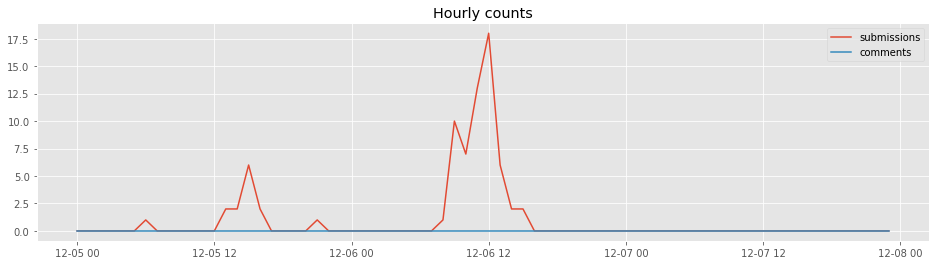

In [37]:
fig, ax = plt.subplots(1, figsize=(16, 4))

date_start, date_end = '2016-12-05', '2016-12-07'
ax.plot(subs_hourly[date_start:date_end], label='submissions')
ax.plot(comms_hourly[date_start:date_end], label='comments')
ax.set_title("Hourly counts")
ax.legend()

#### well, it happened after the election, so I'm not as interested in that, but here are functions to explore the date range, users, and subreddits

In [38]:
def timespan_activity_user_subreddit(df,
                                     fields=['author', 'subreddit'],
                                     resample_by='D',
                                     date_start=None,
                                     date_end=None,
                                     title=None):
    '''
    plot total activity, then break out by author and subreddit
    '''
    range_df = df[date_start:date_end]
    resamp_df = range_df.resample(resample_by).count()
    fig, axs = plt.subplots(3, 1, figsize=(16, 48))
    axs[0].plot(resamp_df['created_utc'].fillna(0))
    axs[0].set_title(title)
    for i, f in enumerate(fields):
        plot_strip_counts(range_df, f, axs[i+1], 
                          title=f'activity by {f}',
                          date_start=date_start,
                          date_end=date_end)

In [39]:
def plot_strip_counts(df, field, ax, title=None, date_start=None, date_end=None):
    for i, val in enumerate(np.unique(df[field])):
        filt_series = df[df[field] == val][date_start:date_end][field]
        ax.scatter(filt_series.index, filt_series, color='blue', alpha=0.25)
        ax.set_ylabel(field)
        ax.set_title(title)

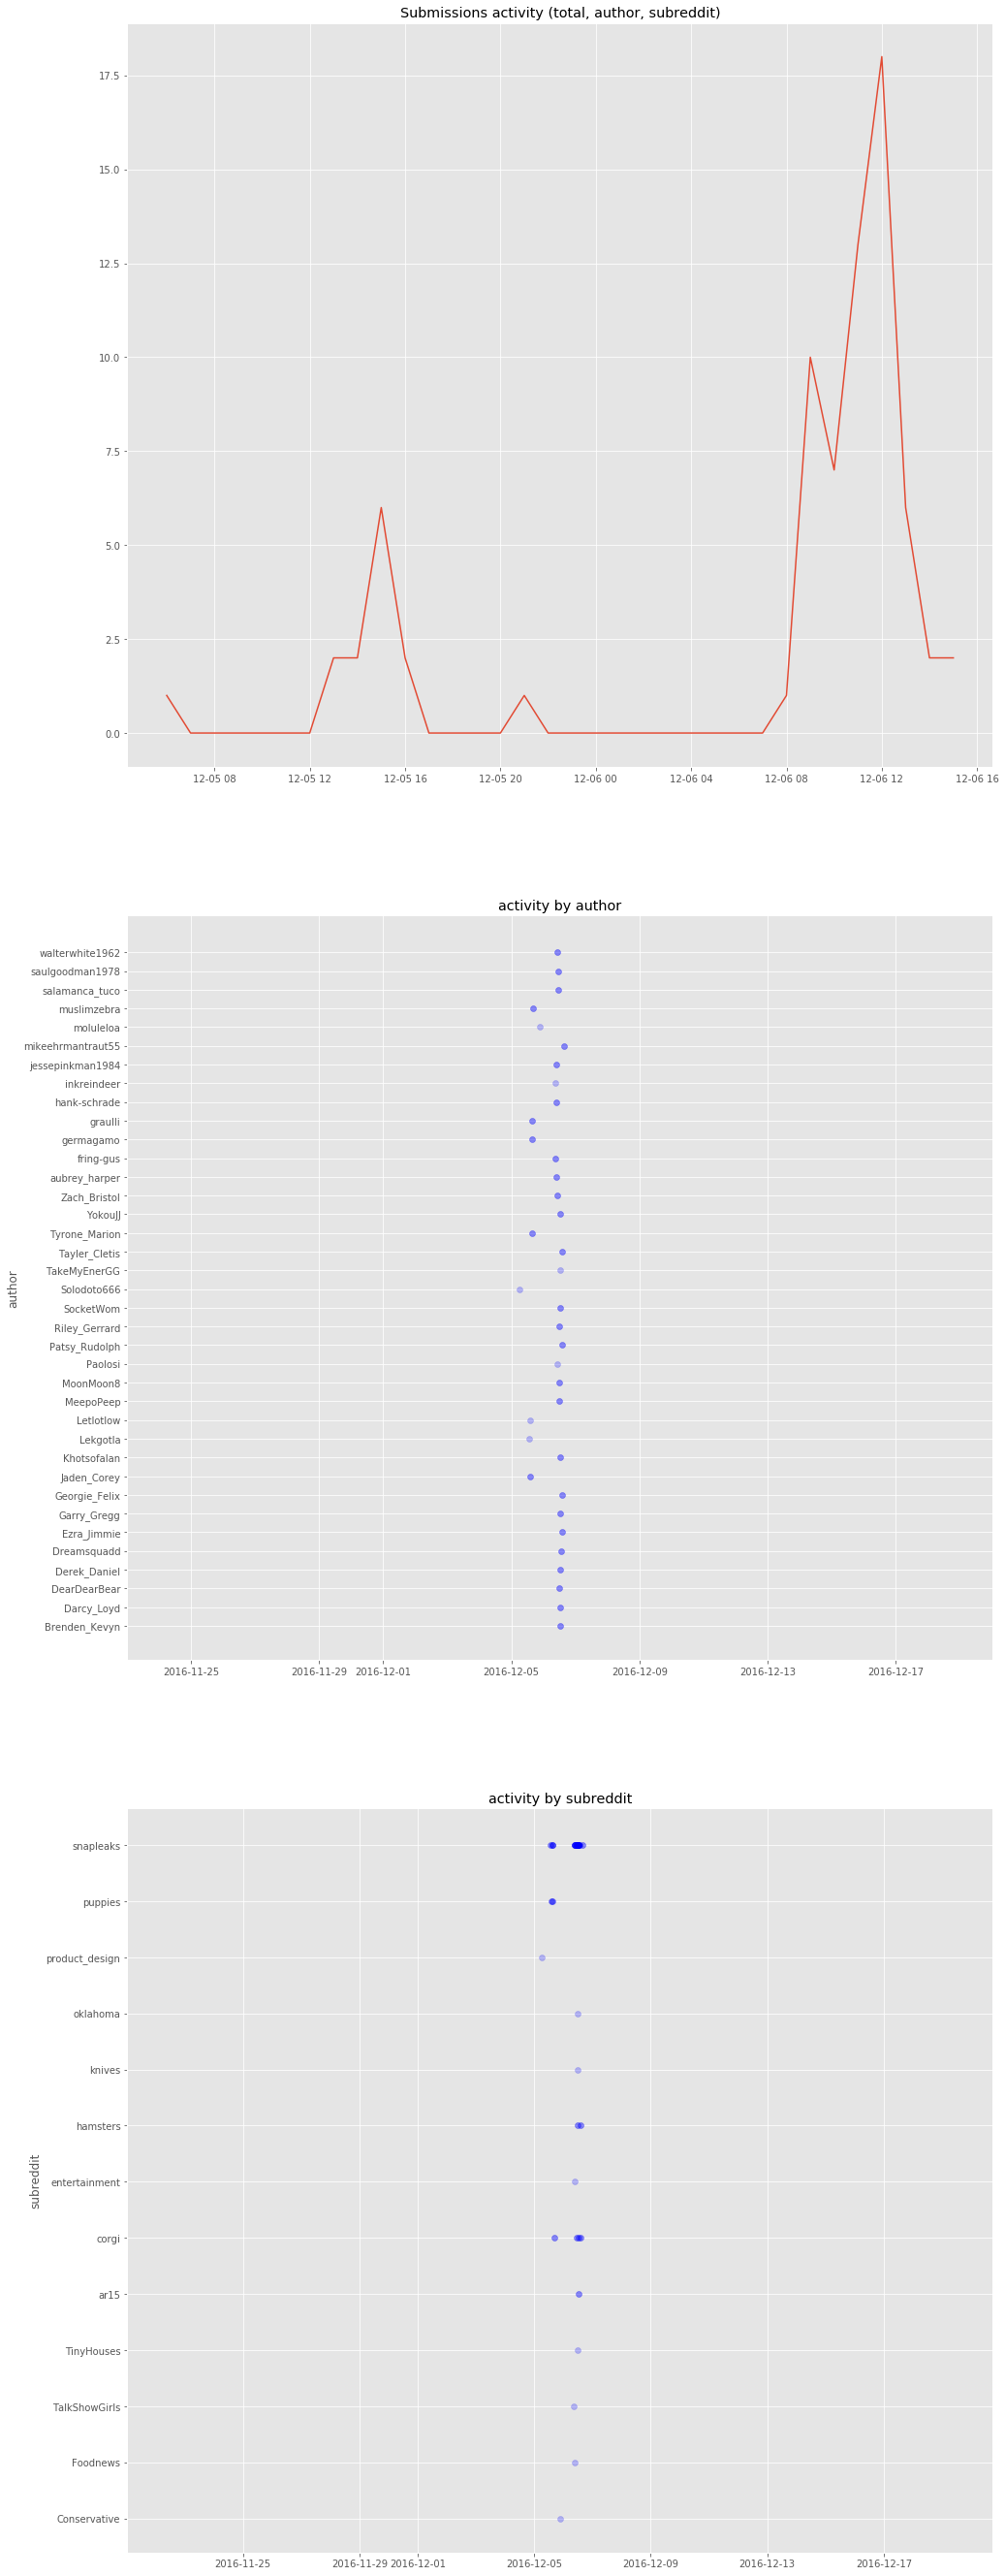

In [40]:
timespan_activity_user_subreddit(subs_df, 
                                 resample_by='H',
                                 date_start='2016-12-05',
                                 date_end='2016-12-07',
                                 title='Submissions activity (total, author, subreddit)')

#### when were the users created?

In [19]:
def plot_activity_with_jitter(ax, series, title=None, label=None):
    jitter = stats.uniform(-1, 2).rvs(len(series))
    x = [dt.fromtimestamp(x) for x in series]
    ax.scatter(x, jitter, alpha=0.5, label=label)
    ax.set_title(title)

In [20]:
comms = comms_df['author_created_utc'].dropna()
subs = subs_df['author_created_utc'].dropna()
len(comms), len(subs)

(289, 600)

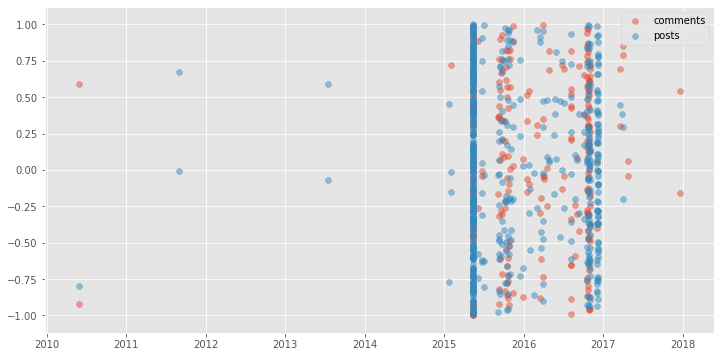

In [21]:
date_s, date_e = '2015-05', '2017-01'
fig, ax = plt.subplots(1, figsize=(12, 6))
titles = ['comments', 'posts']
for i, s in enumerate([comms, subs]):
    plot_activity_with_jitter(ax, s, label=titles[i])
ax.legend()

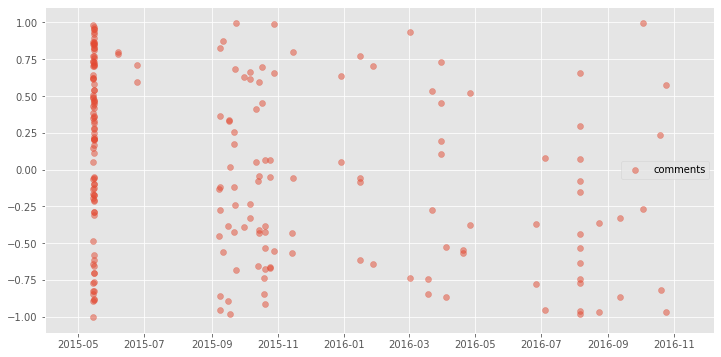

In [23]:
date_s, date_e = '2015-05', '2017-01'
fig, ax = plt.subplots(1, figsize=(12, 6))
titles = ['comments']
for i, s in enumerate([comms[date_s:date_e]]):
    plot_activity_with_jitter(ax, s, label=titles[i])
ax.legend()

#### what is the pattern of author created vs. activity?

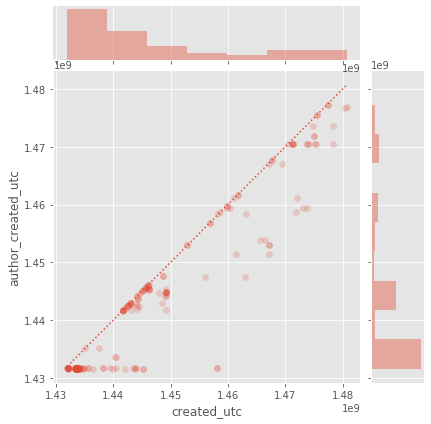

In [44]:
# lines and shading 2d density
range_df = comms_df['2015-05':'2017-01']
axs = sns.jointplot("created_utc", "author_created_utc", 
                    data=range_df, 
                    kind='scatter', 
                    alpha=0.2)
# add the x=y line for comments made immediately following acount creation
x = np.linspace(np.min(range_df['created_utc']), np.max(range_df['created_utc']), 250)
axs.ax_joint.plot(x, x, ':')

## author creation times in same thread, any similarity?

In [59]:
comms_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2016-06-28 05:08:53 to 2015-05-22 13:50:56
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   author                    298 non-null    object 
 1   author_created_utc        289 non-null    float64
 2   author_flair_css_class    9 non-null      object 
 3   author_flair_text         9 non-null      object 
 4   author_fullname           256 non-null    object 
 5   body                      298 non-null    object 
 6   controversiality          256 non-null    float64
 7   created_utc               298 non-null    int64  
 8   distinguished             0 non-null      float64
 9   gilded                    256 non-null    float64
 10  id                        298 non-null    object 
 11  link_id                   298 non-null    object 
 12  nest_level                252 non-null    float64
 13  parent_id                 29

Text(0, 0.5, 'Number of threads')

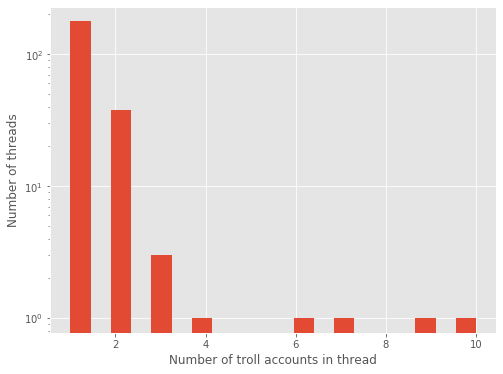

In [31]:
# list(comms_df.['link_id', 'author'], as_index=True)['author_created_utc'])
fig, ax = plt.subplots(1, figsize=(8, 6))
ax = comms_df.groupby(['link_id']).count().sort_values(by='author', ascending=False)['author'].hist(ax=ax, bins=20, log=True)
# comms_df[['id', 'link_id', 'author','author_created_utc']]
ax.set_xlabel('Number of troll accounts in thread')
ax.set_ylabel('Number of threads')

In [24]:
len(np.unique(comms_df['link_id']))

223

In [95]:
# mask = comms_df['link_id'] == 't3_7m1hht'

mask = comms_df['link_id'] == 't3_36j690'

In [96]:
for comment in comms_df[mask.values].items():
    print(comment)

('author', 2015-05-19 19:55:26      AxeseekerMightwind
2015-05-19 19:55:26      AxeseekerMightwind
2015-05-19 19:56:57               DarusCege
2015-05-19 19:56:57               DarusCege
2015-05-19 19:58:06         GavinraraFonara
2015-05-19 19:58:06         GavinraraFonara
2015-05-19 19:56:54    VanecedwaShadowsmith
2015-05-19 19:56:54    VanecedwaShadowsmith
2015-05-19 19:56:06             ZuluraGolar
Name: author, dtype: object)
('author_created_utc', 2015-05-19 19:55:26    1.431695e+09
2015-05-19 19:55:26    1.431695e+09
2015-05-19 19:56:57    1.431695e+09
2015-05-19 19:56:57    1.431695e+09
2015-05-19 19:58:06    1.431685e+09
2015-05-19 19:58:06    1.431685e+09
2015-05-19 19:56:54    1.431614e+09
2015-05-19 19:56:54    1.431614e+09
2015-05-19 19:56:06    1.431687e+09
Name: author_created_utc, dtype: float64)
('author_flair_css_class', 2015-05-19 19:55:26    None
2015-05-19 19:55:26    None
2015-05-19 19:56:57    None
2015-05-19 19:56:57    None
2015-05-19 19:58:06    None
2015-05-

### visualize heatmap of subreddit comment and post activity by trolls

# see https://stackoverflow.com/questions/27988846/how-to-express-classes-on-the-axis-of-a-heatmap-in-seaborn

In [18]:
networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

### network level

In [19]:
network_labels = networks.columns.get_level_values("network")
network_pal = sns.cubehelix_palette(network_labels.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
network_lut = dict(zip(map(str, network_labels.unique()), network_pal))

#### Create index using the columns for networks

In [20]:
network_colors = pd.Series(network_labels, index=networks.columns).map(network_lut)

### node level

In [21]:
node_labels = networks.columns.get_level_values("node")
node_pal = sns.cubehelix_palette(node_labels.unique().size)
node_lut = dict(zip(map(str, node_labels.unique()), node_pal))

#### Create index using the columns for nodes

In [22]:
node_colors = pd.Series(node_labels, index=networks.columns).map(node_lut)

#### Create dataframe for row and column color levels

In [23]:
network_node_colors = pd.DataFrame(network_colors).join(pd.DataFrame(node_colors))

### create clustermap

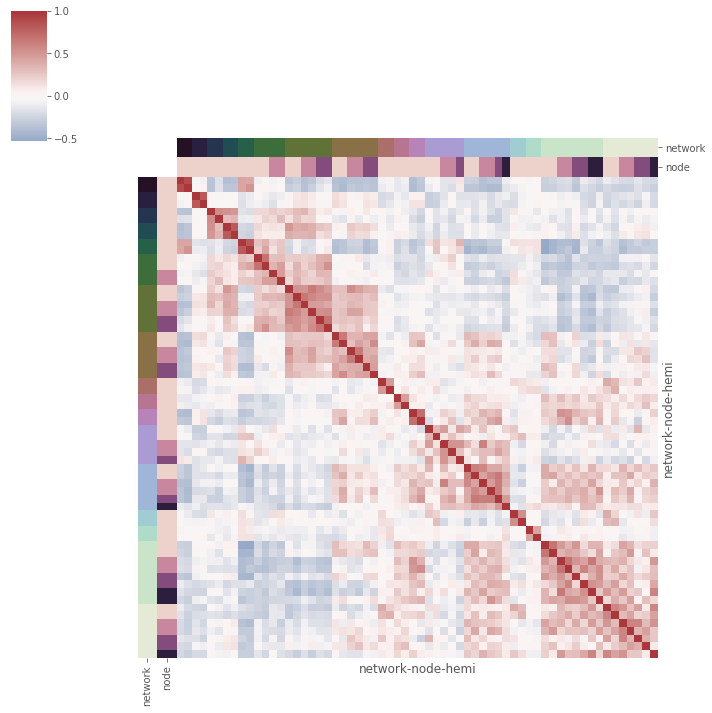

In [24]:
g = sns.clustermap(networks.corr(),
    # Turn off the clustering
    row_cluster=False, col_cluster=False,
    # Add colored class labels using data frame created from node and network colors
    row_colors = network_node_colors,
    col_colors = network_node_colors,
    # Make the plot look better when many rows/cols
    linewidths=0,
    xticklabels=False, yticklabels=False,
    center=0, cmap="vlag")

### create two legends - one for each level by creating invisible column and row barplots (as per above)
#### network legend

In [26]:
for label in network_labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='Network', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.8), bbox_transform=plt.gcf().transFigure)

<Figure size 432x288 with 0 Axes>

#### node legend

In [27]:
for label in node_labels.unique():
    g.ax_row_dendrogram.bar(0, 0, color=node_lut[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Node', loc="center", ncol=2, bbox_to_anchor=(0.8, 0.8), bbox_transform=plt.gcf().transFigure)

plt.show()

<Figure size 432x288 with 0 Axes>

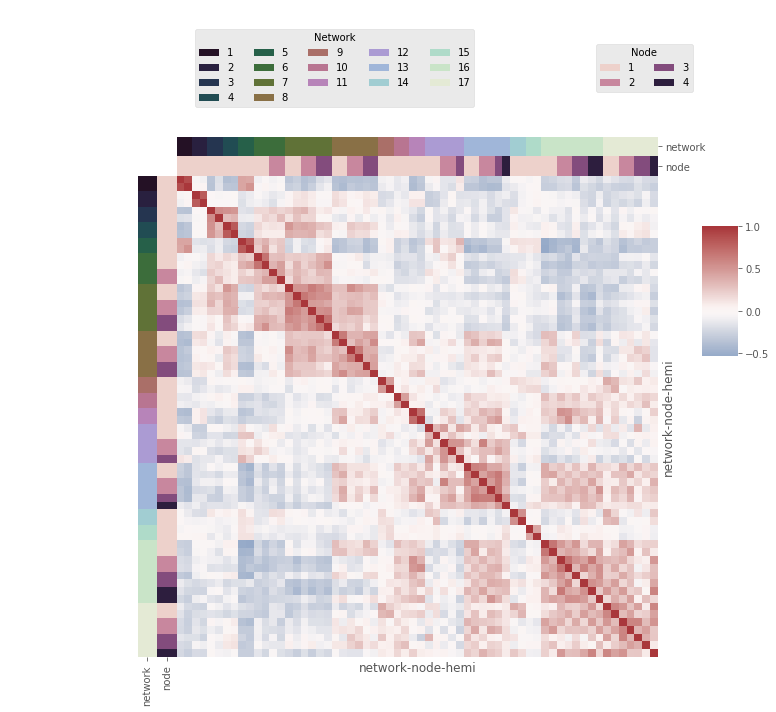

In [36]:
g = sns.clustermap(networks.corr(),
    # Turn off the clustering
    row_cluster=False, col_cluster=False,
    # Add colored class labels using data frame created from node and network colors
    row_colors = network_node_colors,
    col_colors = network_node_colors,
    # Make the plot look better when many rows/cols
    linewidths=0,
    xticklabels=False, yticklabels=False,
    cbar_pos=(0.98, 0.5, 0.05, 0.18),
    center=0, cmap="vlag")

for label in network_labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='Network', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.9), bbox_transform=plt.gcf().transFigure)

for label in node_labels.unique():
    g.ax_row_dendrogram.bar(0, 0, color=node_lut[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Node', loc="center", ncol=2, bbox_to_anchor=(0.9, 0.9), bbox_transform=plt.gcf().transFigure)

plt.show()

In [ ]:
g.add_legend